## Importing the required packages

In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import set_random_seed
print(os.listdir("../input/chest_xray/chest_xray"))

Using TensorFlow backend.


['val', 'train', 'test', '.DS_Store']


## Exploring the dataset 

In [4]:
print(os.listdir("../input/chest_xray/chest_xray/train/"))
print(os.listdir("../input/chest_xray/chest_xray/test/"))
print(os.listdir("../input/chest_xray/chest_xray/val/"))
TRAIN_DIR="../input/chest_xray/chest_xray/train/"
TEST_DIR="../input/chest_xray/chest_xray/test/"


['NORMAL', '.DS_Store', 'PNEUMONIA']
['NORMAL', '.DS_Store', 'PNEUMONIA']
['NORMAL', '.DS_Store', 'PNEUMONIA']


In [5]:
train_NORMAL    = !find ../input/chest_xray/chest_xray/train/NORMAL/ -type f  -exec file {} \+ | grep -c -i 'image'
train_PNEUMONIA = !find ../input/chest_xray/chest_xray/train/PNEUMONIA/ -type f  -exec file {} \+ | grep -c -i 'image'
val_NORMAL      = !find ../input/chest_xray/chest_xray/val/NORMAL/ -type f  -exec file {} \+ | grep -c -i 'image'
val_PNEUMONIA   = !find ../input/chest_xray/chest_xray/val/PNEUMONIA/ -type f  -exec file {} \+ | grep -c -i 'image'
test_NORMAL     = !find ../input/chest_xray/chest_xray/test/NORMAL/ -type f  -exec file {} \+ | grep -c -i 'image'
test_PNEUMONIA  = !find ../input/chest_xray/chest_xray/test/PNEUMONIA/ -type f  -exec file {} \+ | grep -c -i 'image'


train_data = np.array([int(train_NORMAL[0]),int(train_PNEUMONIA[0])])
test_data = np.array([int(test_NORMAL[0]),int(test_PNEUMONIA[0])])
val_data = np.array([int(val_NORMAL[0]),int(val_PNEUMONIA[0])])


### Printing the statistics of dataset

<BarContainer object of 4 artists>

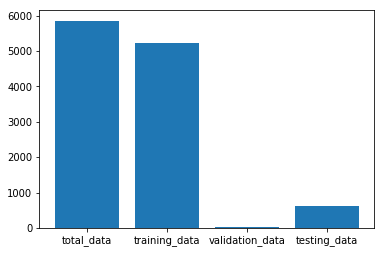

In [6]:
train_data_count=train_data[0]+train_data[1]
test_data_count=test_data[0]+test_data[1]
val_data_count=val_data[0]+val_data[1]
total_data_count=train_data_count+test_data_count+val_data_count
plt.bar(['total_data','training_data','validation_data','testing_data'],[total_data_count,train_data_count,val_data_count,test_data_count])

### Training,Testing,Validation Categories

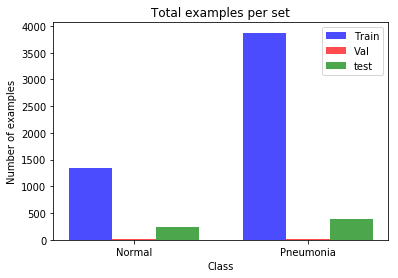

In [7]:
index = np.arange(2)
bar_width = 0.25
opacity = 0.7

rects1 = plt.bar(index, train_data, bar_width,
                alpha=opacity, color='b',
                label='Train')
rects2 = plt.bar(index + bar_width, val_data, bar_width,
                alpha=opacity, color='r', tick_label = ('Normal', 'Pneumonia'),
                label='Val')
rects3 = plt.bar(index + 2*bar_width, test_data, bar_width,
                alpha=opacity, color='g', tick_label = ('Normal', 'Pneumonia'),
                label='test')

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Total examples per set')
plt.xticks(index + bar_width)
plt.legend()

plt.show()

## Preprocessing the Dataset

#### Examining if there are any corrupted images in dataset

In [8]:
from os import listdir
from PIL import Image
    
for filename in TRAIN_DIR:
    if filename.endswith('.jpeg'):
        try:
            img = Image.open('./'+filename) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename) # print out the names of corrupt files
    
for filename in TEST_DIR:
    if filename.endswith('.jpeg'):
        try:
            img = Image.open('./'+filename) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename) # print out the names of corrupt files

#### Since there are no bad files the files are kept as it is.

In [9]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [10]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [11]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

## Visualizing the Dataset

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


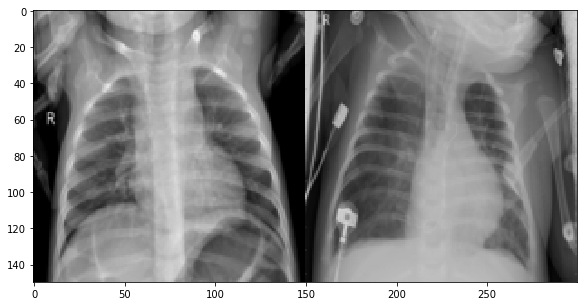

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


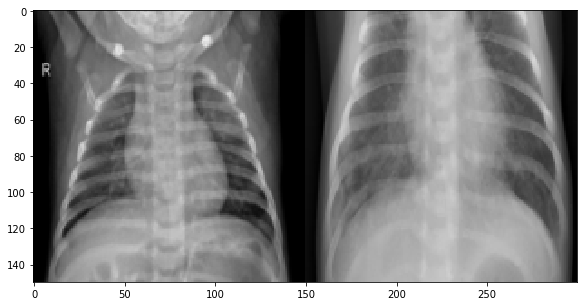

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


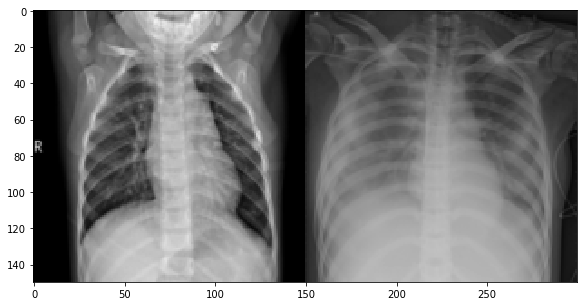

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


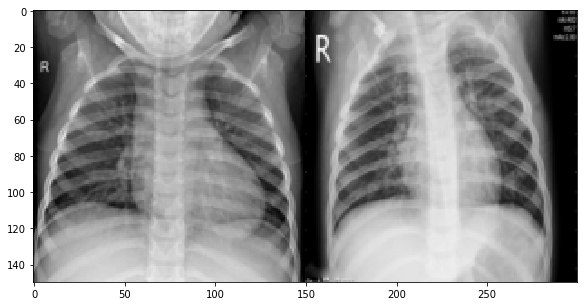

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


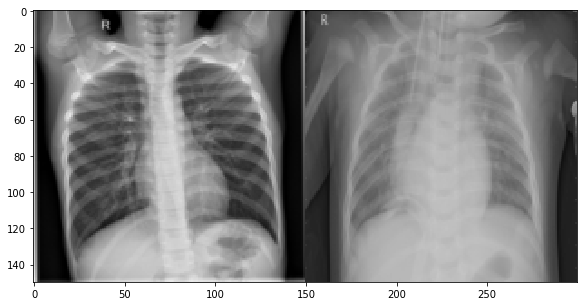

In [12]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [13]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator

In [14]:
from tensorflow import set_random_seed
os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_random_seed(2)

## Benchmark Model

In [15]:
bench_model = Sequential()
bench_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(64,64, 1)))
bench_model.add(MaxPooling2D(pool_size=2))
bench_model.add(Flatten())
bench_model.add(Dense(2, activation='softmax'))

In [16]:
bench_model.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(lr=0.1, decay=1e-6), 
                  metrics=['accuracy'])

In [17]:
bench_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32770     
Total params: 32,850
Trainable params: 32,850
Non-trainable params: 0
_________________________________________________________________


In [18]:
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("../input/chest_xray/chest_xray/train",bench_model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("../input/chest_xray/chest_xray/val", bench_model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("../input/chest_xray/chest_xray/test", bench_model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
history=bench_model.fit_generator(train_batches,validation_data=valid_batches,epochs=4)

Epoch 1/4
326/326 [==============================] - 59s 180ms/step - loss: 11.9420 - acc: 0.2590 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/4
326/326 [==============================] - 58s 178ms/step - loss: 11.9742 - acc: 0.2571 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/4
326/326 [==============================] - 57s 176ms/step - loss: 11.9742 - acc: 0.2571 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/4
326/326 [==============================] - 58s 178ms/step - loss: 11.9742 - acc: 0.2571 - val_loss: 8.0590 - val_acc: 0.5000


In [33]:
p1 = bench_model.predict_generator(test_batches, verbose=True)
pre1 = pd.DataFrame(p)
pre1["filename"] = test_batches.filenames
pre1["label"] = (pre1["filename"].str.contains("PNEUMONIA")).apply(int)
pre1['pre'] = (pre1[1]>0.5).apply(int)

78/78 [==============================] - 5s 69ms/step


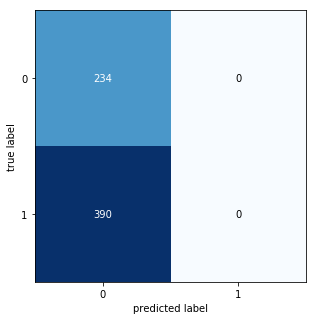

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
y_pred = np.argmax(p1, axis=1)
CM = confusion_matrix(test_batches.classes,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

## Creating the Sequential model

In [20]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same",
                 input_shape=(64,64,1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())

model.add(Dense(2, activation="softmax"))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
__________

In [22]:
import tensorflow as tf
from keras import backend as K
def auc(y_true,y_pred):
    auc=tf.metrics.auc(y_true,y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=[auc])

In [23]:
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("../input/chest_xray/chest_xray/train",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("../input/chest_xray/chest_xray/val", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("../input/chest_xray/chest_xray/test", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
history=model.fit_generator(train_batches,validation_data=valid_batches,epochs=4)

Epoch 1/4
326/326 [==============================] - 60s 184ms/step - loss: 0.4939 - auc: 0.9268 - val_loss: 2.4714 - val_auc: 0.9545
Epoch 2/4
326/326 [==============================] - 60s 183ms/step - loss: 0.4326 - auc: 0.9570 - val_loss: 3.0076 - val_auc: 0.9587
Epoch 3/4
326/326 [==============================] - 59s 181ms/step - loss: 0.2931 - auc: 0.9625 - val_loss: 0.5730 - val_auc: 0.9653
Epoch 4/4
326/326 [==============================] - 60s 184ms/step - loss: 0.3873 - auc: 0.9663 - val_loss: 2.0308 - val_auc: 0.9663


In [25]:
p = model.predict_generator(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

78/78 [==============================] - 6s 71ms/step


In [26]:
recall_score(pre["label"],pre["pre"])


0.9717948717948718

In [27]:
roc_auc_score(pre["label"],pre[1])


0.8393271970195048

### ROC Curve

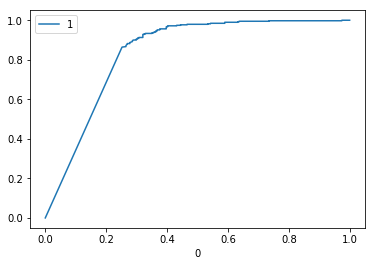

In [28]:
tpr,fpr,thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)

### Confusion Matrix

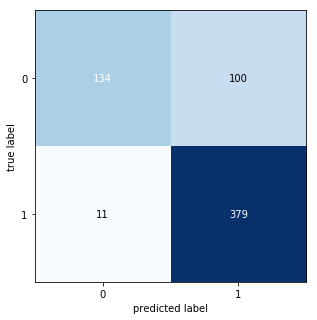

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
y_pred = np.argmax(p, axis=1)
CM = confusion_matrix(test_batches.classes,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [30]:
arget_names = ['Normal', 'Pneumonia']
print(classification_report(test_batches.classes, y_pred, target_names=arget_names))

              precision    recall  f1-score   support

      Normal       0.92      0.57      0.71       234
   Pneumonia       0.79      0.97      0.87       390

   micro avg       0.82      0.82      0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



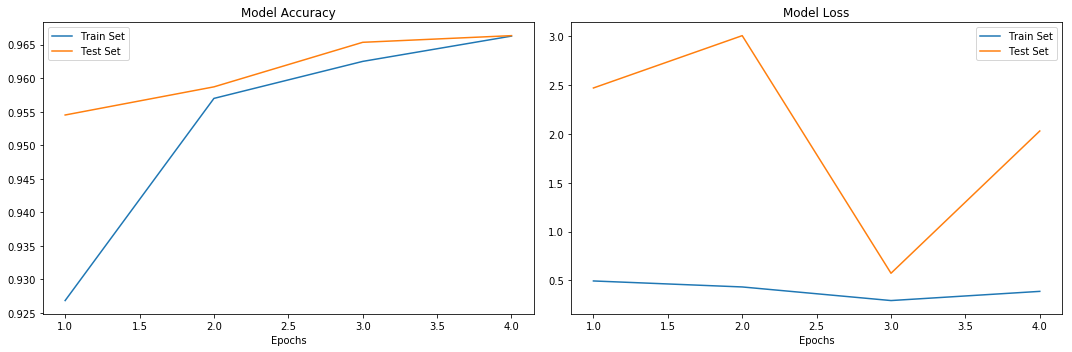

In [31]:
epochs=4
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()